In [30]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define column names for train/test files
columns = ["unit", "time", "op1", "op2", "op3"] + [f"s_{i}" for i in range(1, 22)]

# Define the list of FDxxx files
fd_list = ["FD001", "FD002", "FD003", "FD004"]

# Base folder path for the dataset
base_folder = "/kaggle/input/nasa-cmaps/CMaps"

def load_and_preprocess(fd, base_folder):
    train_file = f"{base_folder}/train_{fd}.txt"
    test_file = f"{base_folder}/test_{fd}.txt"
    rul_file = f"{base_folder}/RUL_{fd}.txt"

    # Load train data
    train_df = pd.read_csv(train_file, sep=" ", header=None, names=columns, engine='python')
    train_df = train_df.dropna(axis=1)  # Drop empty columns

    # Load test data
    test_df = pd.read_csv(test_file, sep=" ", header=None, names=columns, engine='python')
    test_df = test_df.dropna(axis=1)

    # Load RUL data
    rul_df = pd.read_csv(rul_file, header=None, names=["RUL"])
    rul_df['unit'] = rul_df.index + 1  # Add a 'unit' column to match the test_df

    # Calculate RUL for training data
    train_df['RUL'] = train_df.groupby('unit')['time'].transform('max') - train_df['time']

    # Assign RUL to test data using a merge
    test_df = test_df.merge(rul_df, on='unit', how='left')

    return train_df, test_df


In [31]:
# Function to prepare data for LSTM
def create_lstm_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

In [32]:
# Loop through each FDxxx file
results = []
for fd in fd_list:
    print(f"\nProcessing {fd}...\n")
    
    # Load and preprocess data
    train_df, test_df = load_and_preprocess(fd, base_folder)
    time_series = train_df[['time', 'RUL']].set_index('time')
    
    # Split into train/test for ARIMA/SARIMA
    train_size = int(len(time_series) * 0.8)
    train, test = time_series.iloc[:train_size], time_series.iloc[train_size:]
    
    # ----- ARIMA -----
    model_arima = ARIMA(train['RUL'], order=(5, 1, 0))
    arima_result = model_arima.fit()
    arima_forecast = arima_result.forecast(steps=len(test))
    arima_mae = mean_absolute_error(test['RUL'], arima_forecast)
    print(f"{fd} ARIMA MAE: {arima_mae}")
    
    # ----- SARIMA -----
    model_sarima = SARIMAX(train['RUL'], order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
    sarima_result = model_sarima.fit()
    sarima_forecast = sarima_result.forecast(steps=len(test))
    sarima_mae = mean_absolute_error(test['RUL'], sarima_forecast)
    print(f"{fd} SARIMA MAE: {sarima_mae}")
    
    # ----- LSTM -----
    # Normalize data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(time_series)
    
    # Split normalized data into training and testing sets
    scaled_train_data = scaled_data[:train_size]
    scaled_test_data = scaled_data[train_size:]
    
    # Create sliding window data
    window_size = 10
    X_train, y_train = create_lstm_data(scaled_train_data, window_size)
    X_test, y_test = create_lstm_data(scaled_test_data, window_size)
    
    # Check if there is enough test data
    if X_test.shape[0] > 0:
        # Reshape for LSTM (samples, time steps, features)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        
        # Build LSTM model
        lstm_model = Sequential([
            LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
            Dense(1)
        ])
        lstm_model.compile(optimizer='adam', loss='mae')
        lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, verbose=1)
        
        # Predict with LSTM
        lstm_forecast = lstm_model.predict(X_test)
        lstm_forecast = scaler.inverse_transform(lstm_forecast)  # Rescale to original range
        lstm_mae = mean_absolute_error(y_test, lstm_forecast)
        print(f"{fd} LSTM MAE: {lstm_mae}")
    else:
        print(f"{fd} LSTM skipped due to insufficient test data.")
        lstm_mae = None  # Indicate no result for this scenario
    
    # Save results
    results.append({
        "FD": fd,
        "ARIMA_MAE": arima_mae,
        "SARIMA_MAE": sarima_mae,
        "LSTM_MAE": lstm_mae
    })

# Step 9: Compare Results
results_df = pd.DataFrame(results)
print("\nComparison of MAE across all FDxxx scenarios:\n")
print(results_df)



Processing FD001...



/tmp/ipykernel_23/1071656208.py:42: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_df = test_df.merge(rul_df, on='unit', how='left')
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

FD001 ARIMA MAE: 0.0002687858288101226


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.63389D+00    |proj g|=  3.43353D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     50      2     0     0   1.020D+01  -6.636D+00
  F =  -6.6358048478298981     

ABNORMAL_TERMINATION_IN_LNSRCH                              
FD001 SARIMA MAE: 0.000266566940677812
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


928/928 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2282 - val_loss: 0.2176
Epoch 2/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2170 - val_loss: 0.2156
Epoch 3/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2133 - val_loss: 0.2156
Epoch 4/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2137 - val_loss: 0.2158
Epoch 5/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2143 - val_loss: 0.2154
Epoch 6/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2162 - val_loss: 0.2161
Epoch 7/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2145 - val_loss: 0.2155
Epoch 8/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2165 - val_loss: 0.2156
Epoch 9/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2138 - val_loss: 0.2154
Epoch 10/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2162 - val_loss: 0.2155
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
FD001 LSTM MAE: 0.45173266802858886

Processing FD002...



/tmp/ipykernel_23/1071656208.py:42: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_df = test_df.merge(rul_df, on='unit', how='left')
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

FD002 ARIMA MAE: 0.0006595265087801616


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85330D+00    |proj g|=  1.36066D+02


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     28      1     0     0   3.138D+00  -5.855D+00
  F =  -5.8551396988488094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


FD002 SARIMA MAE: 0.0006773866403347329
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2419/2419 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2846 - val_loss: 0.2543
Epoch 2/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2549 - val_loss: 0.2528
Epoch 3/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2546 - val_loss: 0.2518
Epoch 4/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2550 - val_loss: 0.2521
Epoch 5/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2533 - val_loss: 0.2528
Epoch 6/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2543 - val_loss: 0.2523
Epoch 7/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2498 - val_loss: 0.2519
Epoch 8/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2513 - val_loss: 0.2526
Epoch 9/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2526 - val_loss: 0.2527
Epoch 10/10
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2530 - val_loss: 0.2519
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
FD002 LSTM MAE: 0.7358994708823546

Processing FD003...



/tmp/ipykernel_23/1071656208.py:42: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_df = test_df.merge(rul_df, on='unit', how='left')
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

FD003 ARIMA MAE: 0.0002729457057750466
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.62546D+00    |proj g|=  3.43527D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     27      1     0     0   1.083D+01  -6.627D+00
  F =  -6.6274468635218780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


FD003 SARIMA MAE: 0.0002748573605956451
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1112/1112 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2130 - val_loss: 0.1976
Epoch 2/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2000 - val_loss: 0.1985
Epoch 3/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2006 - val_loss: 0.1977
Epoch 4/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1995 - val_loss: 0.1975
Epoch 5/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1994 - val_loss: 0.1971
Epoch 6/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1982 - val_loss: 0.1974
Epoch 7/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1991 - val_loss: 0.2009
Epoch 8/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2011 - val_loss: 0.2001
Epoch 9/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1995 - val_loss: 0.1989
Epoch 10/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1982 - val_loss: 0.1970
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
FD003 LSTM MAE: 0.4497135247869951

Processing FD004...



/tmp/ipykernel_23/1071656208.py:42: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_df = test_df.merge(rul_df, on='unit', how='left')
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

FD004 ARIMA MAE: 0.0005285752544133866


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85503D+00    |proj g|=  1.35383D+02


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     27      1     0     0   7.627D-01  -5.857D+00
  F =  -5.8568531887271194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


FD004 SARIMA MAE: 0.0005387818840532253
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2756/2756 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2771 - val_loss: 0.2503
Epoch 2/10
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2528 - val_loss: 0.2503
Epoch 3/10
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2545 - val_loss: 0.2516
Epoch 4/10
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2527 - val_loss: 0.2501
Epoch 5/10
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2520 - val_loss: 0.2516
Epoch 6/10
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2517 - val_loss: 0.2570
Epoch 7/10
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2538 - val_loss: 0.2500
Epoch 8/10
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2518 - val_loss: 0.2513
Epoch 9/10
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2535 - val_loss: 0.2502
Epoch 10/10
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2543 - val_loss: 0.2536
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
FD004 LSTM MAE: 0.7342086742026813

Comparison of MAE across all FDxxx scenarios:

      


Comparison of MAE across all FDxxx scenarios:

      FD  ARIMA_MAE  SARIMA_MAE  LSTM_MAE
0  FD001   0.000269    0.000267  0.451755
1  FD002   0.000660    0.000677  0.735976
2  FD003   0.000273    0.000275  0.449694
3  FD004   0.000529    0.000539  0.734262


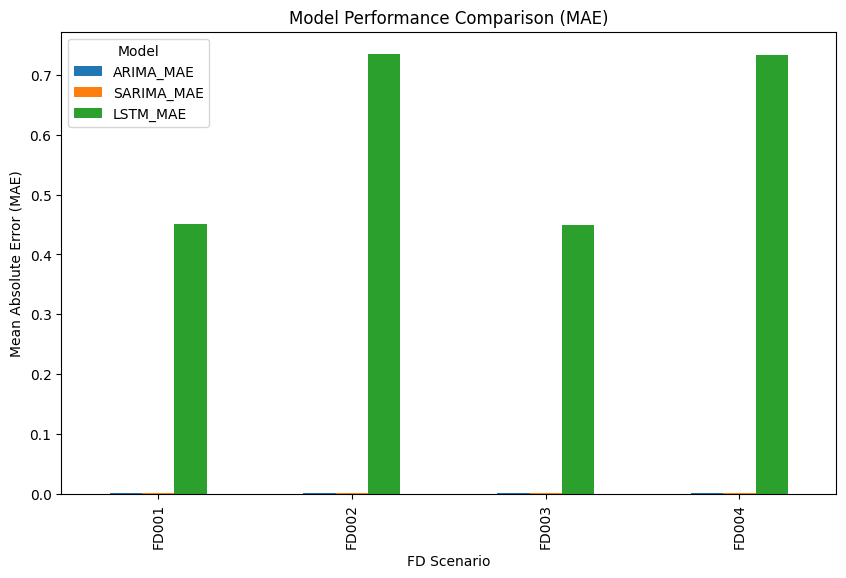

In [11]:
# Step 9: Compare Results
results_df = pd.DataFrame(results)
print("\nComparison of MAE across all FDxxx scenarios:\n")
print(results_df)

# Visualize Results
results_df.set_index("FD")[["ARIMA_MAE", "SARIMA_MAE", "LSTM_MAE"]].plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison (MAE)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("FD Scenario")
plt.legend(title="Model")
plt.show()

 94/645 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/tmp/ipykernel_23/1071656208.py:42: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_df = test_df.merge(rul_df, on='unit', how='left')


645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


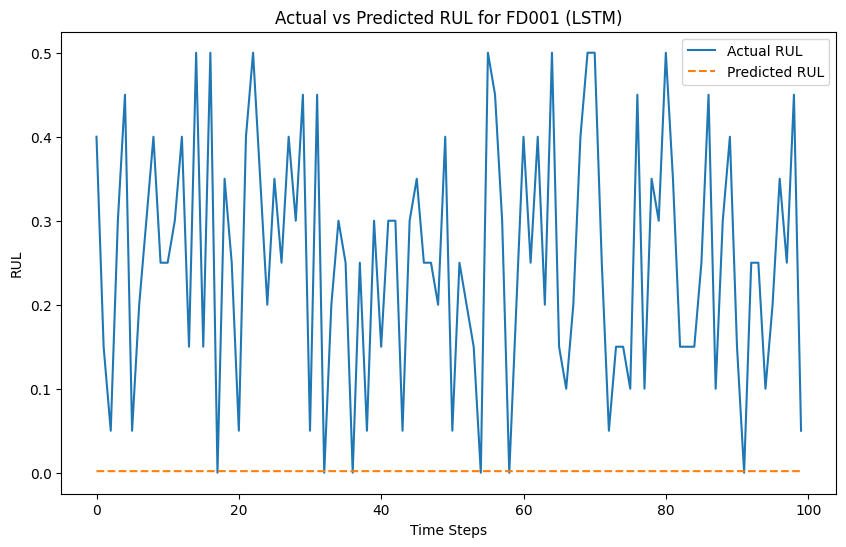

In [13]:
# Visualization for FD001 LSTM
# Extract predictions for FD001
fd = "FD001"
train_df, test_df = load_and_preprocess(fd, base_folder)

# Normalize and prepare test data for visualization
scaled_data = scaler.transform(train_df[['RUL']])
X_test_vis, y_test_vis = create_lstm_data(scaled_data, window_size)
X_test_vis = X_test_vis.reshape(X_test_vis.shape[0], X_test_vis.shape[1], 1)

# Predict with LSTM for FD001
lstm_predicted = lstm_model.predict(X_test_vis)
lstm_predicted_rescaled = scaler.inverse_transform(lstm_predicted)  # Rescale

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_vis[:100], label="Actual RUL")
plt.plot(lstm_predicted_rescaled[:100], label="Predicted RUL", linestyle='--')
plt.title(f"Actual vs Predicted RUL for FD001 (LSTM)")
plt.xlabel("Time Steps")
plt.ylabel("RUL")
plt.legend()
plt.show()


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2757/2757 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2832 - val_loss: 0.2813
Epoch 2/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2798 - val_loss: 0.2815
Epoch 3/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2827 - val_loss: 0.2812
Epoch 4/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2791 - val_loss: 0.2811
Epoch 5/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2790 - val_loss: 0.2817
Epoch 6/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2779 - val_loss: 0.2813
Epoch 7/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2791 - val_loss: 0.2812
Epoch 8/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2788 - val_loss: 0.2811
Epoch 9/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2802 - val_loss: 0.2811
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


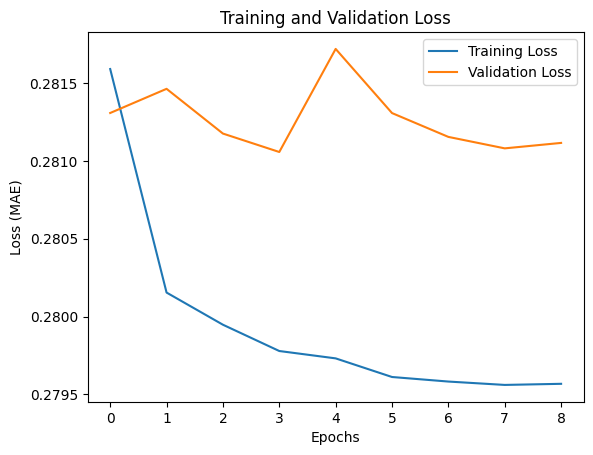

In [33]:
# Dynamically identify sensor columns
sensor_columns = [col for col in train_df.columns if col.startswith('s_')]
features = ['RUL'] + sensor_columns

# Ensure scaler works with available columns
scaled_data = scaler.fit_transform(train_df[features]) 

# Create sliding window data for all features
def create_lstm_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])  # Exclude RUL from input
        y.append(data[i + window_size, -1])  # Use RUL as the target
    return np.array(X), np.array(y)

X, y = create_lstm_data(scaled_data, window_size)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mae')

# Train the LSTM model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = lstm_model.fit(
    X_train,  # Replace with your training features
    y_train,  # Replace with your training labels
    epochs=10,  # Number of epochs
    batch_size=16,  # Batch size
    validation_split=0.1,  # Fraction of data used for validation
    callbacks=[early_stopping],  # Include early stopping
    verbose=1  # Set verbosity level for training output
)

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [34]:
# Evaluate Final MAE on Test Set
test_predictions = lstm_model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_predictions)
print(f"\nValidation Loss Monitoring: Ensure the validation loss decreases consistently.")
print(f"Final MAE for LSTM (Test Set): {test_mae}")

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Validation Loss Monitoring: Ensure the validation loss decreases consistently.
Final MAE for LSTM (Test Set): 0.28185794621594484


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2757/2757 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0688 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 2/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0297 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 3/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0297 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 4/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0297 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 5/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0296 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 6/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0298 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 7/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0295 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 8/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0296 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 9/10
2757/2757 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0295 - val_loss: 0.0295 - learning_rate: 0.0010
Ep

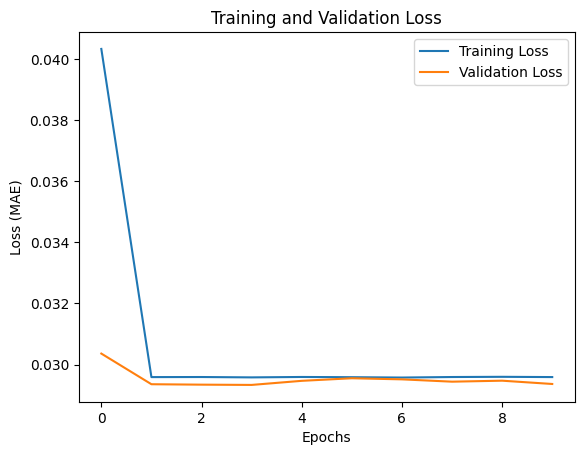

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final MAE for LSTM (Test Set): 0.029142526891567228


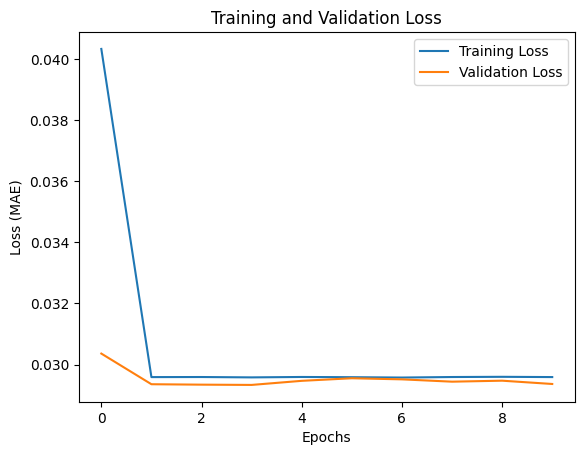

In [36]:
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy as np

# ---- Hyperparameter Tuning and Regularization ----
window_size = 10  # You can try other values like 5, 20
batch_size = 16  # Try changing this to 8, 32, etc.
epochs = 10  # You can experiment with more or fewer epochs

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch > 30:
        return lr * 0.1  # Reduce learning rate after 30 epochs
    return lr

# ---- Feature Engineering ----
# 1. Apply StandardScaler (alternative to MinMaxScaler)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df[features])  # scale based on the selected features

# 2. Optionally apply PCA for dimensionality reduction (e.g., reduce to 10 features)
pca = PCA(n_components=10)
reduced_data = pca.fit_transform(scaled_data)

# ---- Create Sliding Window Data ----
def create_lstm_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])  # Exclude RUL from input
        y.append(data[i + window_size, -1])  # Use RUL as the target
    return np.array(X), np.array(y)

X, y = create_lstm_data(reduced_data, window_size)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# ---- Reshape for LSTM ----
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# ---- Build LSTM Model with Regularization ----
lstm_model = tf.keras.Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), 
         kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    Dropout(0.2),  # Dropout for regularization
    Dense(1)
])

# Compile the model with an Adam optimizer and learning rate scheduler
optimizer = Adam(learning_rate=0.001)  # Starting learning rate
lstm_model.compile(optimizer=optimizer, loss='mae')

# Train the model with validation and learning rate scheduling
history = lstm_model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.1, 
    verbose=1, 
    callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)]
)

# ---- Plot Training and Validation Loss ----
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# ---- Evaluate on Test Set ----
lstm_forecast = lstm_model.predict(X_test)
lstm_mae = mean_absolute_error(y_test, lstm_forecast)

print(f"Final MAE for LSTM (Test Set): {lstm_mae}")

# ---- Save Training History ----
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


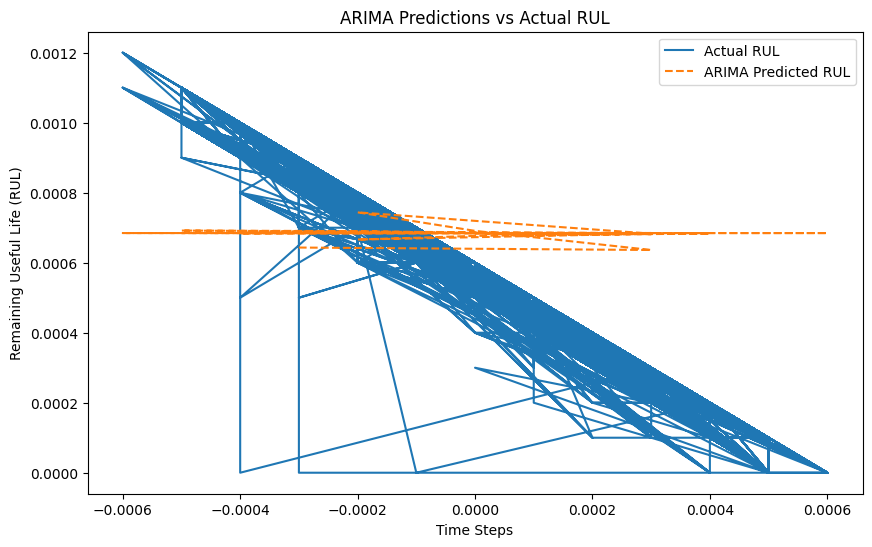

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['RUL'], label='Actual RUL')
plt.plot(test.index, arima_forecast, label='ARIMA Predicted RUL', linestyle='--')
plt.title("ARIMA Predictions vs Actual RUL")
plt.xlabel("Time Steps")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.show()

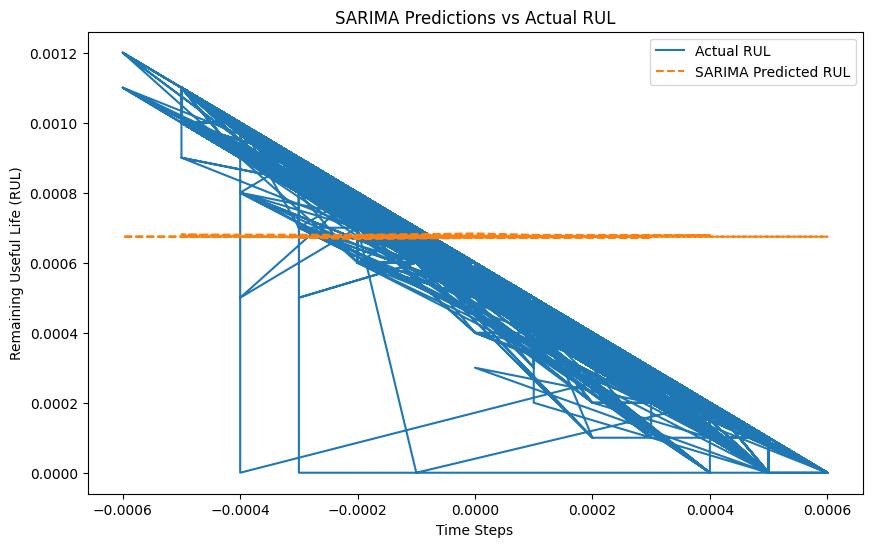

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['RUL'], label='Actual RUL')
plt.plot(test.index, sarima_forecast, label='SARIMA Predicted RUL', linestyle='--')
plt.title("SARIMA Predictions vs Actual RUL")
plt.xlabel("Time Steps")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.show()

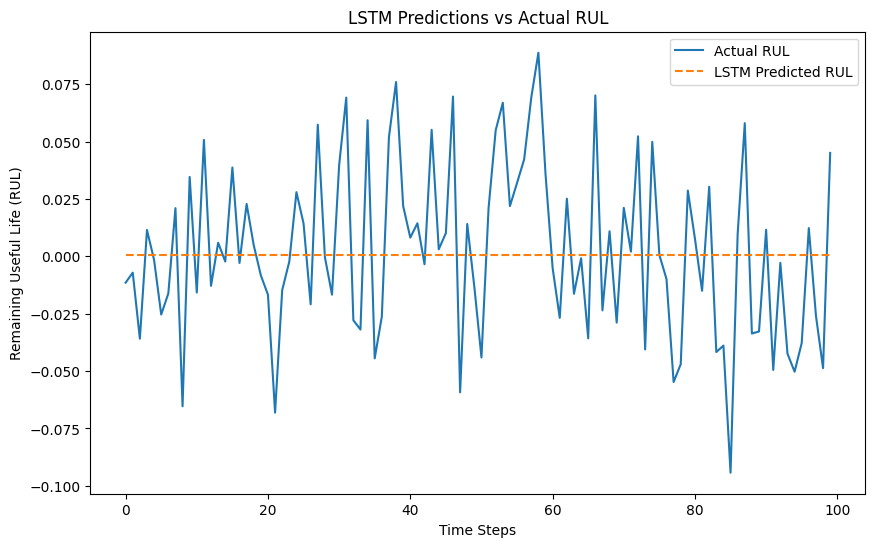

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[:100], label='Actual RUL')
plt.plot(lstm_forecast[:100], label='LSTM Predicted RUL', linestyle='--')
plt.title("LSTM Predictions vs Actual RUL")
plt.xlabel("Time Steps")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.show()


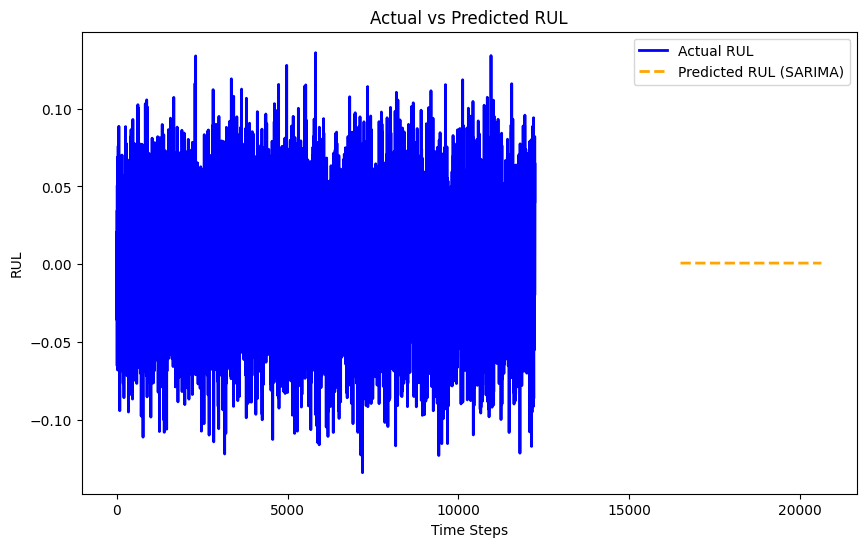

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual RUL", color='blue', linewidth=2)
plt.plot(sarima_forecast, label="Predicted RUL (SARIMA)", color='orange', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted RUL")
plt.xlabel("Time Steps")
plt.ylabel("RUL")
plt.legend()
plt.show()


In [63]:
residuals = y_test - sarima_forecast
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals", color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residuals of SARIMA Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Residuals")
plt.legend()
plt.show()


ValueError: operands could not be broadcast together with shapes (12240,) (4127,) 

In [64]:
print("Actual RUL (first 10):", y_test[:10])
print("Predicted RUL (first 10):", sarima_forecast[:10])


Actual RUL (first 10): [-0.01149179 -0.00712727 -0.03591245  0.01145984 -0.00164791 -0.02538189
 -0.01621326  0.02096429 -0.06535497  0.03455996]
Predicted RUL (first 10): 16504    0.000672
16505    0.000671
16506    0.000684
16507    0.000679
16508    0.000674
16509    0.000671
16510    0.000674
16511    0.000679
16512    0.000680
16513    0.000668
Name: predicted_mean, dtype: float64



Processing FD001...



/tmp/ipykernel_23/2468943207.py:44: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_df = test_df.merge(rul_df, on='unit', how='left')
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

FD001 ARIMA MAE: 0.0005420150956249556


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


FD001 SARIMA MAE: 2.3372738284584684e-06
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


645/645 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1770
Epoch 2/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0631
Epoch 3/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0619
Epoch 4/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0618
Epoch 5/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0614
Epoch 6/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0609
Epoch 7/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0612
Epoch 8/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0622
Epoch 9/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0618
Epoch 10/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0622
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
NaNs in LSTM forecast: False
NaNs in y_test: True
NaNs in LSTM forecast (rescaled): False
NaNs in y_test (rescaled): False
FD001 LSTM MAE: 0.0005496999365277588

Processing FD002...



/tmp/ipykernel_23/2468943207.py:44: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_df = test_df.merge(rul_df, on='unit', how='left')
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

FD002 ARIMA MAE: 0.0014729987124226728


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


FD002 SARIMA MAE: 0.00010366436755083893
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1680/1680 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3318
Epoch 2/10
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1049
Epoch 3/10
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1050
Epoch 4/10
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1051
Epoch 5/10
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1052
Epoch 6/10
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1057
Epoch 7/10
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1054
Epoch 8/10
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1048
Epoch 9/10
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1048
Epoch 10/10
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1050
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
NaNs in LSTM forecast: False
NaNs in y_test: True
NaNs in LSTM forecast (rescaled): False
NaNs in y_test (rescaled): False
FD002 LSTM MAE: 0.48181288872508066

Processing FD003...



/tmp/ipykernel_23/2468943207.py:44: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_df = test_df.merge(rul_df, on='unit', how='left')
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

FD003 ARIMA MAE: 0.0005845673540074452


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


FD003 SARIMA MAE: 1.5968657956974226e-05
Epoch 1/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1496
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0535
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0540
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0537
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0543
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0530
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0541
Epoch 8/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0543
Epoch 9/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0545
Epoch 10/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0536
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
NaNs in LSTM forecast: False
NaNs in y_test: True
NaNs in LSTM forecast (rescaled): False
NaNs in y_test (rescaled): False
FD003 LSTM MAE: 0.0005673273117281497

Processing FD004...



/tmp/ipykernel_23/2468943207.py:44: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_df = test_df.merge(rul_df, on='unit', how='left')
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

FD004 ARIMA MAE: 0.0014688855554018606


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next v

FD004 SARIMA MAE: 4.993729426255065e-06
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1915/1915 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.3146
Epoch 2/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1041
Epoch 3/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1041
Epoch 4/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1050
Epoch 5/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1058
Epoch 6/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1054
Epoch 7/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1045
Epoch 8/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1058
Epoch 9/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1048
Epoch 10/10
1915/1915 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1053
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
NaNs in LSTM forecast: False
NaNs in y_test: True
NaNs in LSTM forecast (rescaled): False
NaNs in y_test (rescaled): False
FD004 LSTM MAE: 0.5372137372898806

Comparison of MAE across all FDxxx scenarios:

      FD  ARIMA_MAE  SARIMA_MAE  LSTM_MAE
0  FD001   0.000542    0.0000

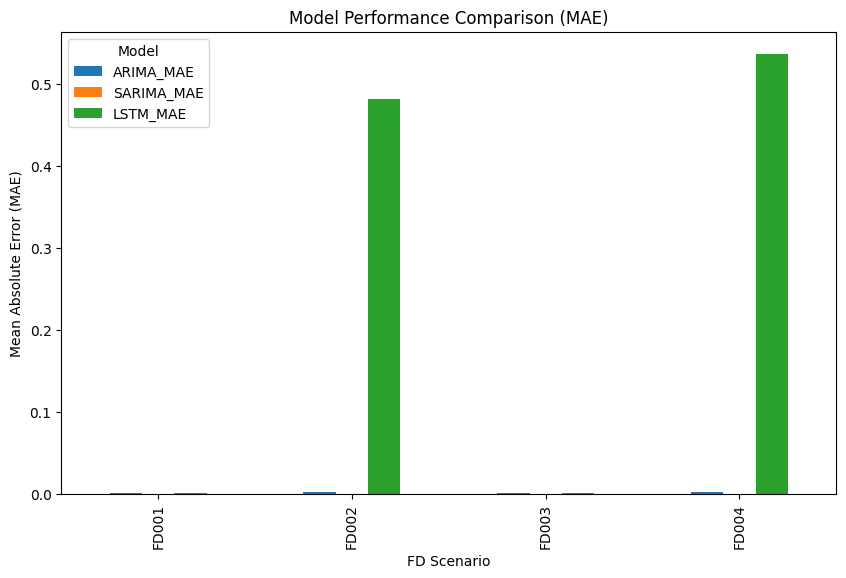

In [69]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define column names for train/test files
columns = ["unit", "time", "op1", "op2", "op3"] + [f"s_{i}" for i in range(1, 22)]

# Define the list of FDxxx files
fd_list = ["FD001", "FD002", "FD003", "FD004"]

# Base folder path for the dataset
base_folder = "/kaggle/input/nasa-cmaps/CMaps"

# Function to load and preprocess data
def load_and_preprocess(fd, base_folder):
    train_file = f"{base_folder}/train_{fd}.txt"
    test_file = f"{base_folder}/test_{fd}.txt"
    rul_file = f"{base_folder}/RUL_{fd}.txt"

    # Load train data
    train_df = pd.read_csv(train_file, sep=" ", header=None, names=columns, engine='python')
    train_df = train_df.dropna(axis=1)  # Drop empty columns

    # Load test data
    test_df = pd.read_csv(test_file, sep=" ", header=None, names=columns, engine='python')
    test_df = test_df.dropna(axis=1)

    # Load RUL data
    rul_df = pd.read_csv(rul_file, header=None, names=["RUL"])
    rul_df['unit'] = rul_df.index + 1  # Add a 'unit' column to match the test_df

    # Calculate RUL for training data
    train_df['RUL'] = train_df.groupby('unit')['time'].transform('max') - train_df['time']

    # Assign RUL to test data using a merge
    test_df = test_df.merge(rul_df, on='unit', how='left')

    return train_df, test_df

# Function to create sliding window data for LSTM
def create_lstm_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])  # Exclude RUL from input
        y.append(data[i + window_size, -1])    # Use RUL as the target
    return np.array(X), np.array(y)

# Initialize results list
results = []

# Loop through each FDxxx file
for fd in fd_list:
    print(f"\nProcessing {fd}...\n")

    # Load and preprocess data
    train_df, test_df = load_and_preprocess(fd, base_folder)
    time_series = train_df[['time', 'RUL']].set_index('time')
    
    # Normalize the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[['RUL']])
    test_scaled = scaler.transform(test_df[['RUL']])
    
    # Split train/test data
    train_size = int(len(time_series) * 0.8)
    train, test = time_series.iloc[:train_size], time_series.iloc[train_size:]
    
    # ----- ARIMA -----
    model_arima = ARIMA(train['RUL'], order=(5, 1, 0))
    arima_result = model_arima.fit()
    arima_forecast = arima_result.forecast(steps=len(test))
    
    # Rescale ARIMA predictions
    arima_forecast_rescaled = scaler.inverse_transform(arima_forecast.values.reshape(-1, 1))
    arima_mae = mean_absolute_error(test['RUL'], arima_forecast_rescaled)
    print(f"{fd} ARIMA MAE: {arima_mae}")

     # ----- SARIMA -----
    # Fit the SARIMA model
    model_sarima = SARIMAX(train['RUL'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_result = model_sarima.fit(disp=False)
    
    # Forecast for the test data length
    sarima_forecast = sarima_result.forecast(steps=len(test))
    
    # Rescale SARIMA predictions
    sarima_forecast_rescaled = scaler.inverse_transform(sarima_forecast.values.reshape(-1, 1))
    
    # Ensure lengths match
    test_rul_rescaled = scaler.inverse_transform(test['RUL'].values.reshape(-1, 1))
    
    # Calculate MAE for SARIMA
    sarima_mae = mean_absolute_error(test_rul_rescaled, sarima_forecast_rescaled)
    print(f"{fd} SARIMA MAE: {sarima_mae}")


         # ----- LSTM -----
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error
    import numpy as np
    
    # Reshape data for LSTM
    X_train = train_scaled[:, :-1].reshape(train_scaled.shape[0], 1, train_scaled.shape[1] - 1)
    y_train = train_scaled[:, -1]
    X_test = test_scaled[:, :-1].reshape(test_scaled.shape[0], 1, test_scaled.shape[1] - 1)
    y_test = test_scaled[:, -1]
    
    # Define LSTM model
    lstm_model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)  # Output a single value
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    
    # Train LSTM
    lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    
    # Predict with LSTM
    lstm_forecast = lstm_model.predict(X_test)
    
    # Check for NaNs in predictions
    print("NaNs in LSTM forecast:", np.isnan(lstm_forecast).any())
    
    # Reshape y_test and check for NaNs
    y_test_reshaped = y_test.reshape(-1, 1)
    print("NaNs in y_test:", np.isnan(y_test_reshaped).any())
    
    # Rescale predictions
    lstm_forecast_rescaled = scaler.inverse_transform(np.nan_to_num(lstm_forecast))  # Replace NaNs with 0
    y_test_rescaled = scaler.inverse_transform(np.nan_to_num(y_test_reshaped))  # Replace NaNs with 0
    
    # Ensure shapes are aligned
    min_length = min(len(lstm_forecast_rescaled), len(y_test_rescaled))
    lstm_forecast_rescaled = lstm_forecast_rescaled[:min_length]
    y_test_rescaled = y_test_rescaled[:min_length]
    
    # Check for NaNs after rescaling
    print("NaNs in LSTM forecast (rescaled):", np.isnan(lstm_forecast_rescaled).any())
    print("NaNs in y_test (rescaled):", np.isnan(y_test_rescaled).any())
    
    # Calculate MAE
    lstm_mae = mean_absolute_error(y_test_rescaled, lstm_forecast_rescaled)
    print(f"{fd} LSTM MAE: {lstm_mae}")


    # Save results
    results.append({
        "FD": fd,
        "ARIMA_MAE": arima_mae,
        "SARIMA_MAE": sarima_mae,
        "LSTM_MAE": lstm_mae
    })

# Step 9: Compare Results
results_df = pd.DataFrame(results)
print("\nComparison of MAE across all FDxxx scenarios:\n")
print(results_df)

# Visualize Results
results_df.set_index("FD")[["ARIMA_MAE", "SARIMA_MAE", "LSTM_MAE"]].plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison (MAE)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("FD Scenario")
plt.legend(title="Model")
plt.show()


In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import numpy as np

# Normalize the data (including additional sensor features)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.iloc[:, 2:])  # Normalize op1, op2, op3, and sensors
test_scaled = scaler.transform(test_df.iloc[:, 2:])

# Create sliding window data for LSTM
def create_lstm_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])  # Use all but the last column (RUL) for input
        y.append(data[i + window_size, -1])    # Use RUL as the target
    return np.array(X), np.array(y)

# Set window size
window_size = 50  # Adjust window size based on data characteristics
X_train, y_train = create_lstm_data(train_scaled, window_size)
X_test, y_test = create_lstm_data(test_scaled, window_size)

# Reshape data for LSTM input
X_train = X_train.reshape(X_train.shape[0], window_size, X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], window_size, X_test.shape[2])

# Define LSTM model with dropout
lstm_model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])
lstm_model.compile(optimizer='adam', loss='mse')

# Callbacks for learning rate reduction and early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train LSTM model
history = lstm_model.fit(
    X_train, y_train,
    epochs=10,  # Increased epochs
    batch_size=16,  # Adjust batch size
    validation_split=0.2,  # Use 20% of data for validation
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Predict with LSTM
lstm_forecast = lstm_model.predict(X_test)

# Rescale predictions
lstm_forecast_rescaled = scaler.inverse_transform(np.hstack([np.zeros((lstm_forecast.shape[0], test_scaled.shape[1] - 1)), lstm_forecast]))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], test_scaled.shape[1] - 1)), y_test.reshape(-1, 1)]))[:, -1]

# Calculate MAE
lstm_mae = mean_absolute_error(y_test_rescaled, lstm_forecast_rescaled)
print(f"LSTM MAE (Improved): {lstm_mae}")

# Optional: Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 0.1187 - val_loss: 0.1043 - learning_rate: 0.0010
Epoch 2/10
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.1078 - val_loss: 0.1045 - learning_rate: 0.0010
Epoch 3/10
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.1066 - val_loss: 0.1044 - learning_rate: 0.0010
Epoch 4/10
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.1058 - val_loss: 0.1042 - learning_rate: 0.0010
Epoch 5/10
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.1055 - val_loss: 0.1044 - learning_rate: 0.0010
Epoch 6/10
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.1052 - val_loss: 0.1041 - learning_rate: 0.0010
Epoch 7/10
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.1058 - val_loss: 0.1041 - learning_rate: 0.0010
Epoch 8/10
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.1059 - val_loss: 0.1042 - learning_rate: 0.0010
Epoch 9/10
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.1049 - val_loss: 0.1042 - lea

ValueError: Input contains NaN.